In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tests.discover as discover

In [2]:
spec = discover.discover_tests('./', 'schlogl')[0][2]

Extending test suite from ./schlogl



In [3]:
rng = np.random.default_rng()
initial_condition = spec.model.make_initial_condition(spec.initial_condition)
factory = spec.simulator_config

k = spec.model.get_k(parameters=spec.parameters, jit=True)
simulator = factory.make_simulator(k, spec.model.stoichiometry(), spec.model.kinetic_order(), species_labels=spec.model.legend())

Evaluating expression: c1 * N1 => 0.03
Evaluating expression: c2 => 0.0001
Evaluating expression: c3 * N2 => 200.0
Evaluating expression: c4 => 3.5


In [4]:
simulator

In [5]:
import pandas as pd

t_eval = np.linspace(0, 10, 101)

def end_routine(result):
    t_history, y_history = result.restricted_values(t_eval, decimal_places=8)
    legend = spec.model.legend()
    df = pd.DataFrame({'time': t_history})
    for i,s in enumerate(legend):
        df[s] = y_history[i, :]
    df = df.set_index('time')
    return df

out = simulator.run_simulations(5, [0.0, 10.0], initial_condition, rng=rng, t_eval=t_eval, end_routine=end_routine)

In [6]:
gillespie_df = pd.concat(out, axis=1)
gillespie_df.columns = ['_'+c for c in gillespie_df.columns]

# Hybrid algorithm with deterministic fast scale

In [7]:
from hybrid.hybrid import HybridSimulator, NThresholdPartitioner

m = spec.model

hs = HybridSimulator(
    m.get_k(parameters=spec.parameters),
    m.stoichiometry(),
    m.kinetic_order(),
    NThresholdPartitioner(1.0)
)

Evaluating expression: c1 * N1 => 0.03
Evaluating expression: c2 => 0.0001
Evaluating expression: c3 * N2 => 200.0
Evaluating expression: c4 => 3.5


In [8]:
out = hs.run_simulations(1, [0.0, 10.0], initial_condition, rng=rng, t_eval=t_eval, end_routine=end_routine)

ode_df = pd.concat(out, axis=1)
ode_df.columns = ['ODE']
ode_df

,ODE
time,
0.0,250.000000
0.1,250.151612
0.2,250.317265
0.3,250.498275
0.4,250.701026
...,...
9.6,569.817975
9.7,569.825779
9.8,569.829930


In [9]:
initial_condition

array([250.])

In [10]:
out = hs.run_simulations(1, [0.0, 10.0], [200.0], rng=rng, t_eval=t_eval, end_routine=end_routine)
out[0].columns = ['_ODE']
ode_df = pd.concat([ode_df, out[0]], axis=1)

In [11]:
ode_df

,ODE,_ODE
time,,
0.0,250.000000,200.000000
0.1,250.151612,196.479924
0.2,250.317265,192.789507
0.3,250.498275,188.928556
0.4,250.701026,184.912015
...,...,...
9.6,569.817975,84.795217
9.7,569.825779,84.795547
9.8,569.829930,84.795764


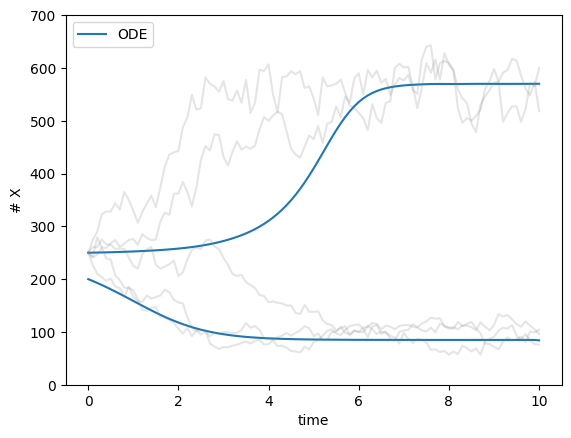

In [12]:
cmap = lambda x: plt.get_cmap("tab10")(0)
ax = ode_df.plot(colormap=cmap, ylabel='# X', ylim=[0, 700])
gillespie_df.plot(ax=ax, colormap=lambda x: 'grey', alpha=0.2, legend=False)
ax.legend(loc='upper left')
plt.savefig('schlogl_gillespie.png', bbox_inches='tight', dpi=300)

# Hybrid algorithm with CLE for fast scale

In [13]:
hs = HybridSimulator(
    m.get_k(parameters=spec.parameters),
    m.stoichiometry(),
    m.kinetic_order(),
    NThresholdPartitioner(100.0),
    fast_scale='langevin',
    approximate_rtot=True,
    contrived_no_reaction_rate=100.
)

Evaluating expression: c1 * N1 => 0.03
Evaluating expression: c2 => 0.0001
Evaluating expression: c3 * N2 => 200.0
Evaluating expression: c4 => 3.5


In [20]:
out = hs.run_simulations(5, [0.0, 10.0], initial_condition, rng=rng, t_eval=t_eval, end_routine=end_routine)
hs_df = pd.concat(out, axis=1)
hs_df.columns = ['_'+c for c in hs_df.columns]

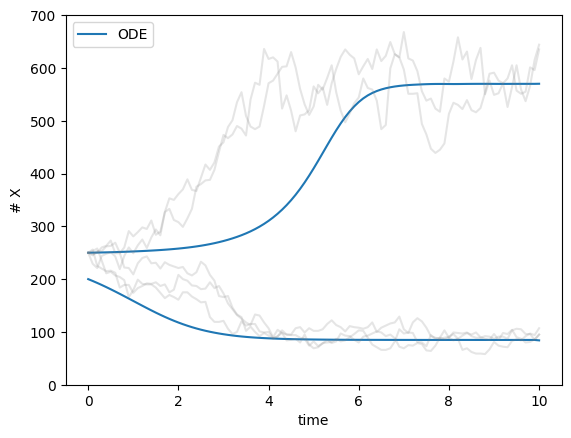

In [30]:
ax = ode_df.plot(colormap=cmap, ylabel='# X', ylim=[0, 700])
hs_df.plot(ax=ax, colormap=lambda x: 'grey', alpha=0.2, legend=False)
ax.legend(loc='upper left')
plt.savefig('schlogl_hybrid_cle.png', bbox_inches='tight', dpi=300)

# Tau leaping

In [22]:
from hybrid.tau import TauLeapSimulator

ts = TauLeapSimulator(
    m.get_k(parameters=spec.parameters),
    m.stoichiometry(),
    m.kinetic_order(),
)

Evaluating expression: c1 * N1 => 0.03
Evaluating expression: c2 => 0.0001
Evaluating expression: c3 * N2 => 200.0
Evaluating expression: c4 => 3.5


In [28]:
out = ts.run_simulations(5, [0.0, 10.0], initial_condition, rng=rng, t_eval=t_eval, end_routine=end_routine)
ts_df = pd.concat(out, axis=1)
ts_df.columns = ['_'+c for c in hs_df.columns]